# Glauber on infinite random $k$-regular graph
Compute magnetization in the thermodynamic limit $N\to\infty$.

Reproduce the results in *Barthel et. al*, [Matrix product algorithm for stochastic dynamics on networks applied to nonequilibrium Glauber dynamics](https://doi.org/10.1103/PhysRevE.97.010104) for $T=50, J=β=1, h=0, m⁰ = 0.5, k=3$.

In [1]:
using MatrixProductBP, MatrixProductBP.Models
using Plots
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

┌ Info: Precompiling MatrixProductBP [3d39929c-b583-45fa-b331-3f50b693a38a]
└ @ Base loading.jl:1662


In [54]:
T = 50         # final time
k = 3          # degree
m⁰ = 0.5       # magnetization at time zero

β = 1.0
J = 1.0
h = 0.0;

In [55]:
wᵢ = fill(HomogeneousGlauberFactor(J, h, β), T+1)
ϕᵢ = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T]
bp = mpbp_infinite_graph(k, wᵢ, ϕᵢ)
cb = CB_BP(bp);

In [56]:
svd_trunc = TruncBond(18)
maxiter = 100
tol = 1e-3
iters, cb = iterate!(bp; maxiter, svd_trunc, cb, tol);

Running MPBP: iter 45 	 Time: 0:26:16
  Δ:  0.0007766849179612509

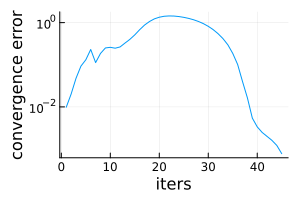

In [57]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, size=(300,200), label="")

In [58]:
b = beliefs(bp)[1]
m = marginal_to_expectation.(b, HomogeneousGlauberFactor);

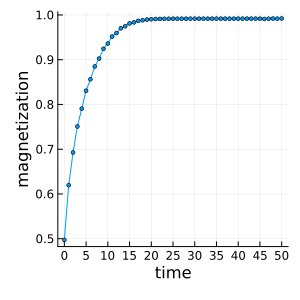

In [59]:
plot(0:T, m, m=:o, xlabel="time", ylabel="magnetization", label="",
    size=(300,300), xticks=0:5:T, ms=2)

In [60]:
c = autocovariances(bp)[1];

In [61]:
using ColorSchemes
function plot_autocovs(c, T; skip_even=true, kw...)
    step = skip_even ? 2 : 1
    us = 8:4:28
    cg = cgrad(:matter, length(us), categorical=true)
    ylabel = "\$\\langle\\sigma_i^t\\sigma_i^{t+\\Delta t}\\rangle-" * 
        "\\langle\\sigma_i^t\\rangle\\langle\\sigma_i^{t+\\Delta t}\\rangle \$"
    xlabel = "\$\\Delta t \$"
    pl = plot(;xlabel, ylabel, legend=:outertopright, title="Glauber infinite $k-regular")
     
    for (j,u) in enumerate(us)
        plot!(pl, u:-step:1, c[(0:step:u-1) .+ 1,u+1], label="t+Δt=$u", c=cg[j], m=:o, msc=cg[j]; kw...) 
    end
    pl
end  

plot_autocovs (generic function with 1 method)

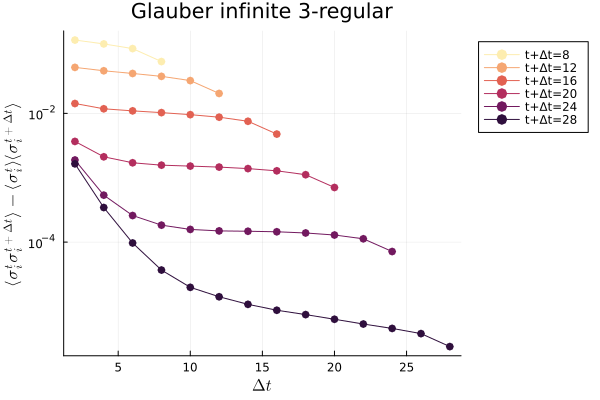

In [62]:
skip_even = true
pl_autocov = plot_autocovs(c, T; skip_even, yaxis=:log10)